In [1]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# For image manipulation
import cv2
import imutils

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras.models import Model

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
import os
import shutil
import random
import pickle

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

## Data
Pituitary, no tumor, meningioma, and glioma images (7023 total, ~80/20 train test split): https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Other tumor images (1177 T1C+ images that I will use): https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c

In [2]:
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

# Create a new directory named "other" in the train directory
new_train_dir = os.path.join(train_dir, 'other')
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)

# Create a new directory named "other" in the test directory
new_test_dir = os.path.join(test_dir, 'other')
if not os.path.exists(new_test_dir):
    os.makedirs(new_test_dir)

In [3]:
supplement_labels = ['Astrocitoma T1C+', 'Carcinoma T1C+', 'Ependimoma T1C+', 'Ganglioglioma T1C+',
                'Germinoma T1C+', 'Granuloma T1C+', 'Meduloblastoma T1C+', 'Neurocitoma T1C+',
                'Oligodendroglioma T1C+', 'Papiloma T1C+', 'Schwannoma T1C+', 'Tuberculoma T1C+']

supplement_path = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/supplement/'

# move 80% of images to the new "other" directory in train_dir and 20% to the new "other" directory in test_dir
for label in supplement_labels:
    folder_path = os.path.join(supplement_path, label)
    files = os.listdir(folder_path)
    random.shuffle(files)
    num_files = len(files)
    num_train_files = int(num_files * 0.8)
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]
    files_moved = 0
    
    for filename in train_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_train_dir, filename)
            shutil.move(src_path, dst_path)
            files_moved += 1

    for filename in test_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_test_dir, filename)
            shutil.move(src_path, dst_path)
            files_moved += 1

In [4]:
labels = ['pituitary', 'notumor', 'meningioma', 'glioma', 'other']

X_train = []
y_train = []

for label in labels:
    for image in os.listdir(train_dir+label):
        X_train.append(train_dir+label+'/'+image)
        y_train.append(label)

In [5]:
X_test = []
y_test = []

for label in labels:
    for image in os.listdir(test_dir+label):
        X_test.append(test_dir+label+'/'+image)
        y_test.append(label)

In [6]:
X_train, y_train = shuffle(X_train, y_train)

In [7]:
tumor_train_df = pd.concat([pd.Series(X_train, name = 'paths'), 
                            pd.Series(y_train, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0967.jpg,glioma
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1139.jpg,notumor
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0090.jpg,meningioma
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_0509.jpg,pituitary
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0245.jpg,notumor
...,...,...
6638,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0085.jpg,glioma
6639,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0559.jpg,notumor
6640,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0832.jpg,notumor
6641,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0206.jpg,notumor


In [8]:
X_test, y_test = shuffle(X_test, y_test)

In [9]:
tumor_test_df = pd.concat([pd.Series(X_test, name = 'paths'), 
                            pd.Series(y_test, name = 'label')], 
                            axis = 1)
tumor_test_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/5._big_gallery.jpeg,other
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0224.jpg,glioma
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0082.jpg,pituitary
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/Anonymize.Seq14.Ser14.Img16_big_gallery.jpeg,other
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0279.jpg,pituitary
...,...,...
1552,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/117._big_gallery.jpeg,other
1553,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0054.jpg,glioma
1554,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0274.jpg,pituitary
1555,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0106.jpg,glioma


## Exploratory Data Analysis

In [10]:
tumor_train_df.shape

(6643, 2)

In [11]:
tumor_train_df['label'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
other          931
Name: label, dtype: int64

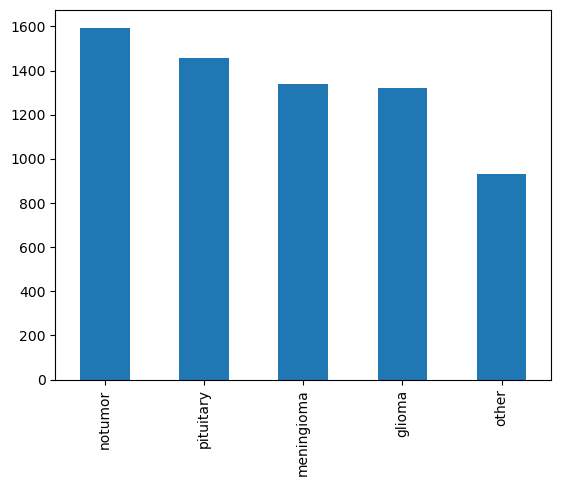

In [12]:
tumor_train_df['label'].value_counts().plot(kind = 'bar');

In [13]:
tumor_test_df['label'].value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
other         246
Name: label, dtype: int64

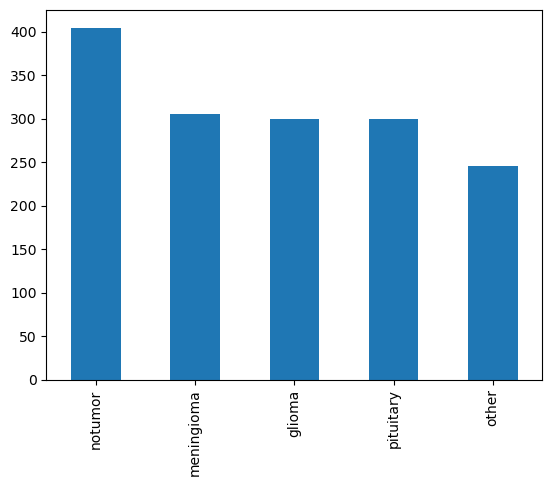

In [14]:
tumor_test_df['label'].value_counts().plot(kind = 'bar');

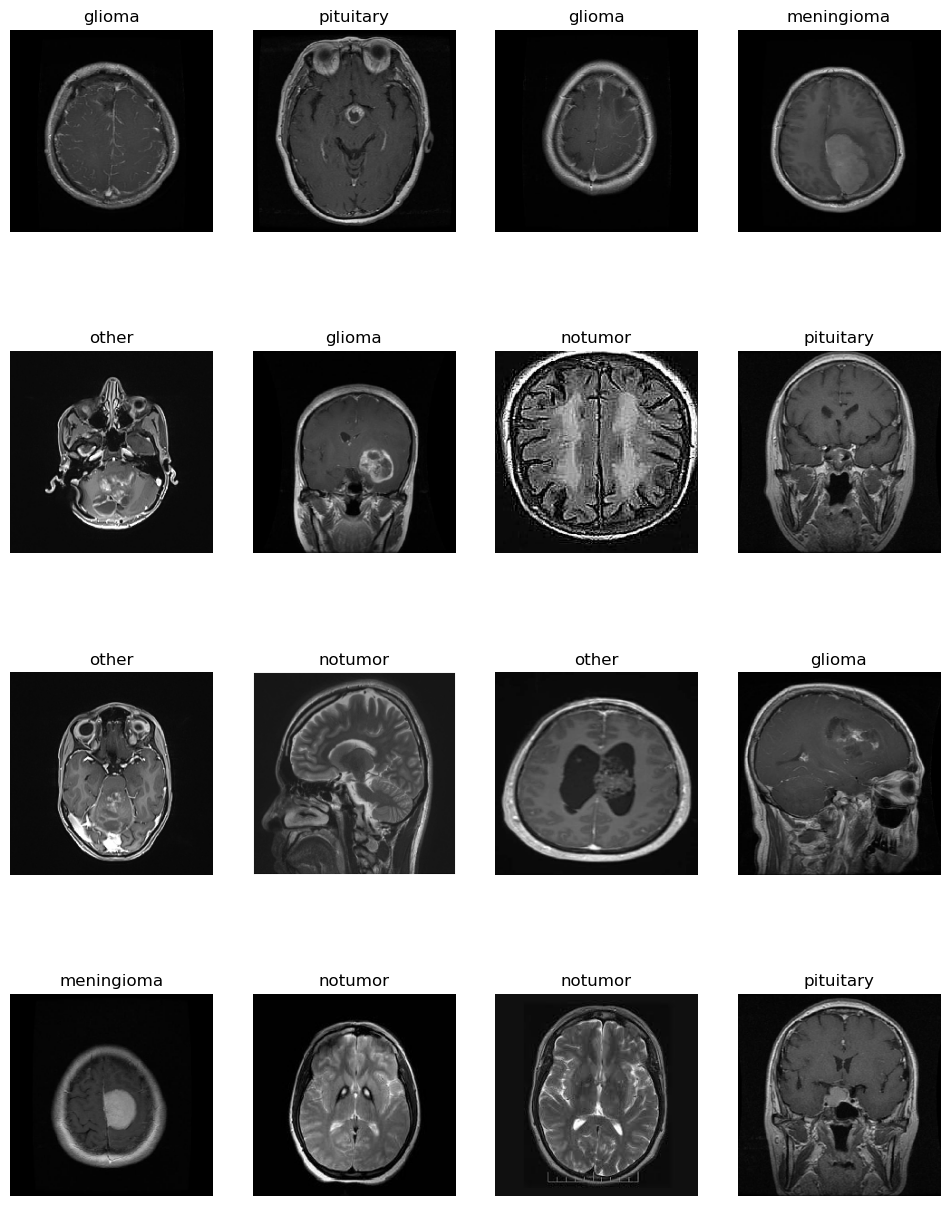

In [15]:
# with gratitude to MD Mushfirat Mohaimin for this code
# https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96

IMAGE_SIZE = (224, 224)

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMAGE_SIZE)
        images.append(image)
    return np.array(images, dtype=object)

images = open_images(X_train[50:67])
labels = y_train[50:67]
fig = plt.figure(figsize=(12, 16))
for x in range(1, 17):
    fig.add_subplot(4, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Baseline Model

In [16]:
train_datagen_baseline = ImageDataGenerator(rescale=1./255)
test_datagen_baseline = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator_baseline = train_datagen_baseline.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

test_generator_baseline = test_datagen_baseline.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [17]:
cce = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
callback = EarlyStopping(monitor='loss', patience=5)

In [18]:
model = Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
base_model = model.fit(train_generator_baseline,
                       verbose = 1,
                       validation_data = test_generator_baseline, 
                       epochs=30,
                       callbacks = [callback])

2023-04-12 17:05:13.380466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-12 17:05:13.380585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Epoch 1/30


2023-04-12 17:05:13.588815: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-12 17:05:13.749623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


207/208 [============================>.] - ETA: 0s - loss: 1.4919 - accuracy: 0.5778

2023-04-12 17:05:23.228630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 12s 55ms/step - loss: 1.4890 - accuracy: 0.5783 - val_loss: 1.0517 - val_accuracy: 0.6859
Epoch 2/30
208/208 [==============================] - 10s 47ms/step - loss: 0.7238 - accuracy: 0.7379 - val_loss: 0.7924 - val_accuracy: 0.7386
Epoch 3/30
208/208 [==============================] - 10s 47ms/step - loss: 0.5999 - accuracy: 0.7865 - val_loss: 0.8134 - val_accuracy: 0.7065
Epoch 4/30
208/208 [==============================] - 10s 47ms/step - loss: 0.4893 - accuracy: 0.8258 - val_loss: 0.7159 - val_accuracy: 0.7232
Epoch 5/30
207/208 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8474

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(base_model.history['accuracy'])
plt.plot(base_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(base_model.history['loss'])
plt.plot(base_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Data Augmentation and Second Model

In [19]:
train_datagen_aug = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       brightness_range=[0.75, 1.25],
                                       rotation_range = 15)
test_datagen_aug = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

test_generator_aug = test_datagen_aug.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [20]:
model_conv = Sequential()
model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1)))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(128, activation='relu'))
model_conv.add(layers.Dense(5, activation='softmax'))
model_conv.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
conv_model = model_conv.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50)

Epoch 1/50


2023-04-12 17:06:32.964377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.1860 - accuracy: 0.5459

2023-04-12 17:06:54.191652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 23s 110ms/step - loss: 1.1860 - accuracy: 0.5459 - val_loss: 0.9506 - val_accuracy: 0.6712
Epoch 2/50
208/208 [==============================] - 24s 113ms/step - loss: 0.7239 - accuracy: 0.7245 - val_loss: 0.7583 - val_accuracy: 0.7444
Epoch 3/50
208/208 [==============================] - 24s 113ms/step - loss: 0.5791 - accuracy: 0.7794 - val_loss: 0.5801 - val_accuracy: 0.7881
Epoch 4/50
208/208 [==============================] - 23s 112ms/step - loss: 0.4984 - accuracy: 0.8142 - val_loss: 0.5896 - val_accuracy: 0.7881
Epoch 5/50
208/208 [==============================] - 23s 111ms/step - loss: 0.4245 - accuracy: 0.8452 - val_loss: 0.4676 - val_accuracy: 0.8317
Epoch 6/50
208/208 [==============================] - 23s 110ms/step - loss: 0.3823 - accuracy: 0.8591 - val_loss: 0.5074 - val_accuracy: 0.8054
Epoch 7/50
208/208 [==============================] - 23s 109ms/step - loss: 0.3609 - accuracy: 0.8695 - val_loss: 0.4085 - val_accuracy: 0.8


KeyboardInterrupt



In [ ]:
# summarize history for accuracy
plt.plot(conv_model.history['accuracy'])
plt.plot(conv_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(conv_model.history['loss'])
plt.plot(conv_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 3: With Normalization and Dropout Layers

In [21]:
reg = l2(1e-2)

model_conv_drop = Sequential()
model_conv_drop.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1), kernel_regularizer = reg))
model_conv_drop.add(BatchNormalization())
model_conv_drop.add(layers.MaxPooling2D((2, 2)))
model_conv_drop.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = reg))
model_conv_drop.add(BatchNormalization())
model_conv_drop.add(layers.MaxPooling2D((2, 2)))
model_conv_drop.add(layers.Flatten())
model_conv_drop.add(layers.Dense(256, activation='relu'))
model_conv_drop.add(Dropout(0.3))
model_conv_drop.add(layers.Dense(64, activation='relu'))
model_conv_drop.add(layers.Dense(5, activation='softmax'))
model_conv_drop.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
conv_drop_model = model_conv_drop.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50)

Epoch 1/50


2023-04-12 17:09:27.968004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 19/208 [=>............................] - ETA: 20s - loss: 87.1674 - accuracy: 0.3388

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(conv_drop_model.history['accuracy'])
plt.plot(conv_drop_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(conv_drop_model.history['loss'])
plt.plot(conv_drop_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# model_conv_drop.save('/Users/eli/Desktop/brain_tumor_CNN_classifier/final_model')

## Transfer Learning - VGG

In [22]:
train_generator_vgg = train_datagen_aug.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1990,
        shuffle = False)

test_generator_vgg = test_datagen_aug.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [23]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

output = vgg.layers[-1].output
output = layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
input_shape = vgg_model.output_shape[1]

In [24]:
vggmodel = Sequential()
vggmodel.add(vgg_model)
vggmodel.add(layers.Flatten())
vggmodel.add(Dense(512, activation='relu', input_dim=input_shape))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(512, activation='relu'))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(5, activation='softmax'))

vggmodel.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

vgg_model_feats = vggmodel.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=30,
                       callbacks = [callback])

Epoch 1/30


2023-04-12 17:09:44.966727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 22/208 [==>...........................] - ETA: 47s - loss: 10.7769 - accuracy: 0.3210

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(vgg_model_feats.history['accuracy'])
plt.plot(vgg_model_feats.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_model_feats.history['loss'])
plt.plot(vgg_model_feats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### VGG With Fine-Tuning

In [ ]:
vgg_model.summary()

In [25]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

output = vgg.layers[-1].output
output = layers.Flatten()(output)
vgg_model_finetune = Model(vgg.input, output)
    
input_shape = vgg_model_finetune.output_shape[1]

vgg_model_finetune.trainable = True
set_trainable = False
for layer in vgg_model_finetune.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
vgg_model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [27]:
vggmodel_finetune = Sequential()
vggmodel_finetune.add(vgg_model_finetune)
vggmodel_finetune.add(layers.Flatten())
vggmodel_finetune.add(Dense(512, activation='relu', input_dim=input_shape))
vggmodel_finetune.add(Dropout(0.3))
vggmodel_finetune.add(Dense(512, activation='relu'))
vggmodel_finetune.add(Dropout(0.3))
vggmodel_finetune.add(Dense(5, activation='softmax'))

vggmodel_finetune.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

vgg_model_finetune = vggmodel_finetune.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=30,
                       callbacks = [callback])

Epoch 1/30


2023-04-12 17:09:58.292863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 78/208 [==========>...................] - ETA: 39s - loss: 59.0366 - accuracy: 0.3106

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(vgg_model_finetune.history['accuracy'])
plt.plot(vgg_model_finetune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_model_finetune.history['loss'])
plt.plot(vgg_model_finetune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_conv = model_conv_drop.predict(test_generator_aug, batch_size = batch_size)
y_pred_vgg = vggmodel_finetune.predict(test_generator_vgg)

In [ ]:
y_pred_classes_conv = np.argmax(y_pred_conv, axis=1)
y_true_classes_conv = test_generator_aug.classes
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)
y_true_classes_vgg = test_generator_vgg.classes

In [ ]:
test_generator_aug.class_indices.keys()

In [ ]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(y_true_classes_conv, y_pred_classes_conv, 
                                        display_labels = ['glioma', 'meningioma', 'notumor', 'other', 'pituitary'],
                                        xticks_rotation = 45,
                                        ax = ax)
# ConfusionMatrixDisplay.from_predictions(y_true_classes_vgg, y_pred_classes_vgg, ax = ax[1]);

In [ ]:
results = model_conv_drop.evaluate(test_generator_aug, batch_size = batch_size)

In [ ]:
print(classification_report(test_generator_aug.classes, y_pred_classes_conv))

In [ ]:
for name, value in zip(model_conv_drop.metrics_names, results):
    print(name, ': ', value)
print()